In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [6]:
len(data_ready)

2361

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.018*"write" + 0.017*"article" + 0.017*"time" + 0.009*"look" + '
  '0.008*"bike" + 0.007*"tell" + 0.007*"new" + 0.007*"well" + 0.006*"first" + '
  '0.006*"start"'),
 (1,
  '0.034*"team" + 0.029*"game" + 0.018*"player" + 0.018*"play" + '
  '0.016*"season" + 0.014*"year" + 0.012*"hockey" + 0.012*"win" + '
  '0.010*"score" + 0.009*"blue"'),
 (2,
  '0.025*"armenian" + 0.013*"people" + 0.011*"kill" + 0.011*"israeli" + '
  '0.009*"government" + 0.009*"state" + 0.008*"genocide" + 0.007*"publish" + '
  '0.007*"turkish" + 0.007*"turk"'),
 (3,
  '0.014*"people" + 0.011*"believe" + 0.009*"law" + 0.008*"question" + '
  '0.008*"book" + 0.007*"talk" + 0.007*"claim" + 0.007*"answer" + '
  '0.007*"exist" + 0.007*"write"')]


In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8879,"write, article, time, look, bike, tell, new, w...","[summary, worth, expire, sit, much, model, clo..."
1,1,0.0,0.4654,"write, article, time, look, bike, tell, new, w...","[lotsa_point, reply, message, organization, se..."
2,2,1.0,0.5248,"team, game, player, play, season, year, hockey...","[abc_coverage, write, boy, rip, espns, hockey,..."
3,3,2.0,0.6352,"armenian, people, kill, israeli, government, s...","[report, yesterday, follow, egyptian, prominen..."
4,4,3.0,0.6289,"people, believe, law, question, book, talk, cl...","[question, authority, trendy, liberal, feminis..."
5,5,3.0,0.5035,"people, believe, law, question, book, talk, cl...","[harrasse, work, prayer, reply, repeat, emphas..."
6,6,0.0,0.9719,"write, article, time, look, bike, tell, new, w...","[apparently, last, post, little, hasy, call, p..."
7,7,3.0,0.5092,"people, believe, law, question, book, talk, cl...","[computing, way, look, die, release, time, abl..."
8,8,1.0,0.4440,"team, game, player, play, season, year, hockey...","[canadien, organization, write, team, problem,..."
9,9,1.0,0.8772,"team, game, player, play, season, year, hockey...","[team, point, team, bind, position, center, dr..."


In [9]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9885,"write, article, time, look, bike, tell, new, well, first, start","[jamie_burnside, bike, organization, give, advice, recommend, bike, compression, test, compressi..."
1,1.0,0.9930,"team, game, player, play, season, year, hockey, win, score, blue","[result, game, play, night, boxscore, result, game, play, standing, clinch, division, title, cli..."
2,2.0,0.8939,"armenian, people, kill, israeli, government, state, genocide, publish, turkish, turk","[method, employ, armenian, genocide, muslim, people, reply, source, man, armenian, officer, part..."
3,3.0,0.9599,"people, believe, law, question, book, talk, claim, answer, exist, write","[rsv, work, love, call, accord, purpose, wrong, quite, familiar, amplification, commentary, murp..."


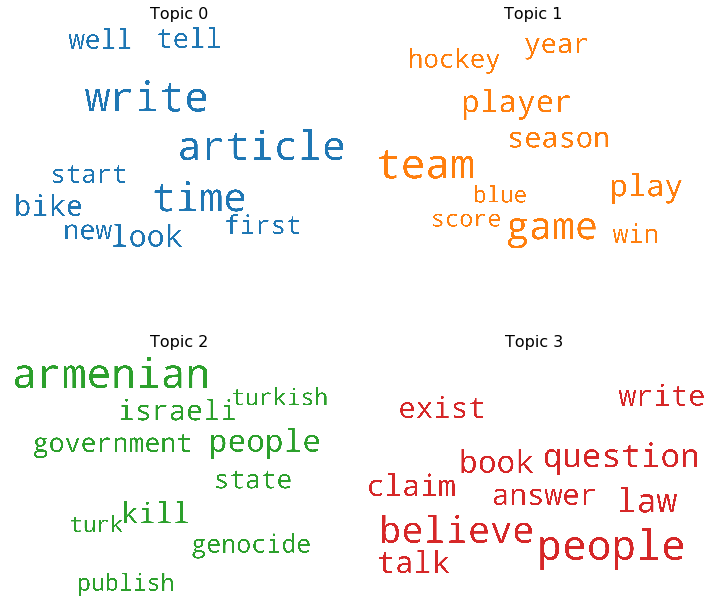

In [10]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

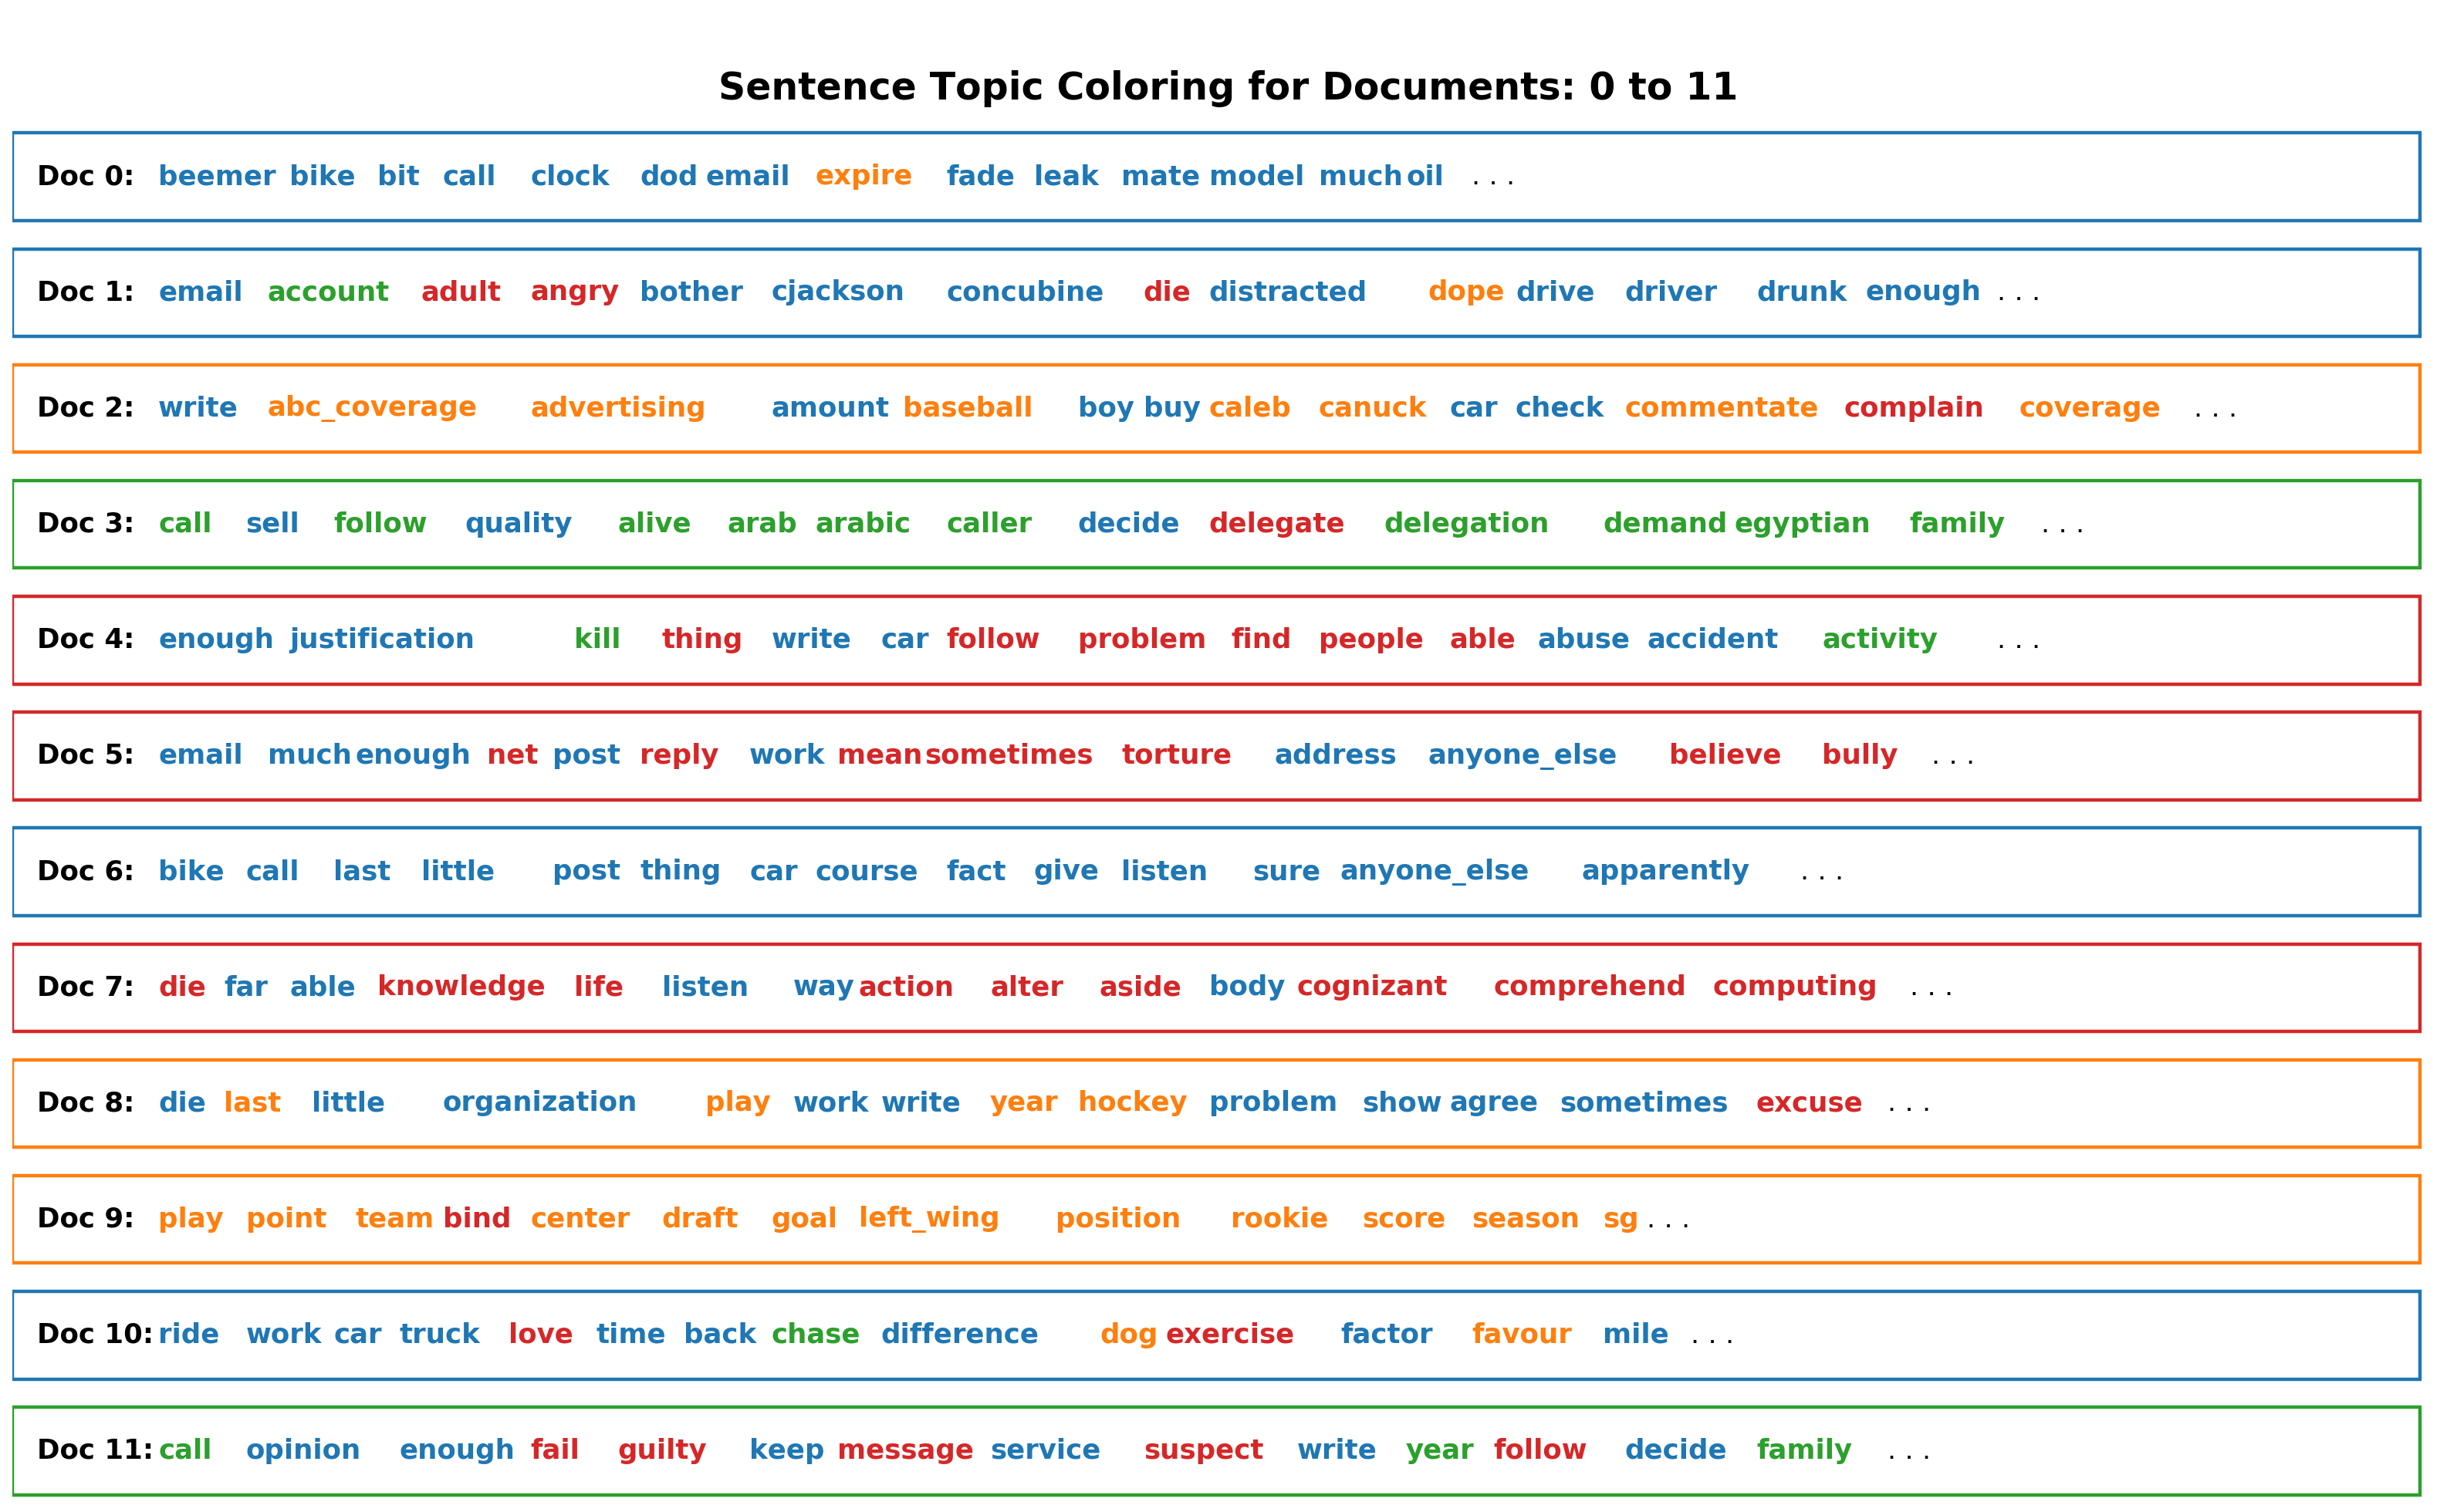

In [11]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

In [15]:
df_dominant_topic[df_dominant_topic['Document_No']==3]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
3,3,2.0,0.6352,"armenian, people, kill, israeli, government, state, genocide, publish, turkish, turk","[report, yesterday, follow, egyptian, prominent, latter, principle, decide, participate, peace_t..."


In [17]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/gateam/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.050474 -0.138978       1        1  37.502342
3     -0.161923 -0.144210       2        1  30.027712
2     -0.116282  0.277425       3        1  19.869787
1      0.328678  0.005763       4        1  12.600162, topic_info=     Category         Freq           Term        Total  loglift  logprob
397   Default   986.000000           team   986.000000  30.0000  30.0000
1136  Default  1130.000000       armenian  1130.000000  29.0000  29.0000
916   Default   843.000000           game   843.000000  28.0000  28.0000
373   Default  1486.000000           time  1486.000000  27.0000  27.0000
1835  Default   521.000000         player   521.000000  26.0000  26.0000
57    Default   507.000000           play   507.000000  25.0000  25.0000
409   Default   446.000000         season   446.000000  24.0000  24.0000
289   Default   731.000000        believe   731.000000  23.0000  23.0000
80    Default   908.000000           year   908.000000  22.0000  22.0000
49    Default   486.000000           kill   486.000000  21.0000  21.0000
1684  Default   479.000000        israeli   479.000000  20.0000  20.0000
101   Default   353.000000         hockey   353.000000  19.0000  19.0000
152   Default  1743.000000         people  1743.000000  18.0000  18.0000
399   Default   348.000000            win   348.000000  17.0000  17.0000
546   Default   602.000000            law   602.000000  16.0000  16.0000
358   Default   730.000000           look   730.000000  15.0000  15.0000
112   Default   627.000000          point   627.000000  14.0000  14.0000
512   Default   413.000000     government   413.000000  13.0000  13.0000
1     Default   655.000000           bike   655.000000  12.0000  12.0000
983   Default   522.000000           book   522.000000  11.0000  11.0000
445   Default  1641.000000        article  1641.000000  10.0000  10.0000
408   Default   291.000000          score   291.000000   9.0000   9.0000
321   Default   495.000000           talk   495.000000   8.0000   8.0000
1186  Default   366.000000       genocide   366.000000   7.0000   7.0000
162   Default   589.000000          state   589.000000   6.0000   6.0000
238   Default   588.000000            new   588.000000   5.0000   5.0000
1386  Default   268.000000           blue   268.000000   4.0000   4.0000
175   Default   464.000000         answer   464.000000   3.0000   3.0000
506   Default   451.000000          exist   451.000000   2.0000   2.0000
404   Default   259.000000           goal   259.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
1284   Topic4   189.210999           pick   189.955078   2.0675  -5.0216
1040   Topic4   167.642609       division   168.414307   2.0669  -5.1427
1075   Topic4   143.904037            ice   144.616730   2.0665  -5.2954
925    Topic4   166.768936        penalty   167.605209   2.0665  -5.1479
927    Topic4   138.497787        playoff   139.197342   2.0664  -5.3336
403    Topic4   144.412582          draft   145.154770   2.0663  -5.2918
3507   Topic4   136.153046            pit   136.853424   2.0663  -5.3507
1113   Topic4   132.897369            fan   133.613266   2.0661  -5.3749
2113   Topic4   131.252167           hawk   131.979797   2.0659  -5.3874
2104   Topic4   121.604164       schedule   122.320190   2.0656  -5.4637
1635   Topic4   121.799973          sport   122.554466   2.0653  -5.4621
6673   Topic4   124.284622          arena   125.057304   2.0653  -5.4419
1521   Topic4   126.982887          tough   127.781670   2.0652  -5.4205
1596   Topic4   115.206490          coach   115.934608   2.0652  -5.5178
977    Topic4   122.149696          trade   122.922012   2.0652  -5.4593
883    Topic4   118.448914           knee   119.215736   2.0650  -5.4900
1824   Topic4   103.932953  hockey_league   104.671700   2.0644  -5.6208
2091   Topic4    94.672684         league    95.394348  